In [28]:
# Standard Libraries
import pandas as pd
import numpy as np
import json
from time import time
# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

pd.set_option('display.max_rows', 20)

import warnings
warnings.filterwarnings('ignore')

import datetime
today = datetime.date.today().strftime("%d-%m-%Y")
print(today)

17-02-2021


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Setup & Preprocessing

In [29]:
paths = 'data/test_hs_code.xlsx'
def get_master(sheets):
    data = pd.read_excel(paths,sheet_name= sheets)
    data['section'] = data['section'].map('{:02}'.format)
    data = data[['section','description']]
    data['description'] = data['description'].str.lower()
 #   data = data.rename(columns={'heading' : 'target', 'product_desc' : 'question_text'})
    data.columns = ['category', 'text']
    
    return data

In [30]:
%%time
print("Load the dataset.......")

t0 = time()

sheets = '8_digit'
eights = get_master(sheets)
sheets = '6_digit'
sixs = get_master(sheets)
sheets = '4_digit'
fours = get_master(sheets)
sheets = '2_digit'
twos = get_master(sheets)


df = pd.concat([eights,sixs,fours,twos], ignore_index=True)
load_time = time() - t0
print("Load dataset time:  %0.3fs" % load_time)

print("size : ", len(df))
df

Load the dataset.......
Load dataset time:  126.558s
size :  17219
Wall time: 2min 6s


In [31]:
hs_df = df.drop_duplicates()
hs_df

,category,text
0,01,"horses; live, purebred breeding animals - pure..."
1,01,"horses; live, other than purebred breeding ani..."
2,01,asses; live - other
3,01,mules and hinnies; live- other
4,01,"cattle; live, purebred breeding animals - pure..."
...,...,...
17214,19,arms and ammunition; parts and accessories the...
17215,20,"furniture; bedding, mattresses, mattress suppo..."
17216,20,"toys, games and sports requisites; parts and a..."
17217,20,miscellaneous manufactured articles


In [32]:
hs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15869 entries, 0 to 17218
Data columns (total 2 columns):
category    15869 non-null object
text        15869 non-null object
dtypes: object(2)
memory usage: 371.9+ KB


In [33]:
hs_df['category'].value_counts()

16    2654
06    2203
11    2085
15    1647
01     944
      ... 
08     178
14     148
12     146
19      49
21      17
Name: category, Length: 21, dtype: int64

In [34]:
# Associate Category names with numerical index and save it in new column category_id
# Associate Category names with numerical index and save it in new column category_id
hs_df['category_id'] = hs_df['category'].factorize()[0]
hs_df

,category,text,category_id
0,01,"horses; live, purebred breeding animals - pure...",0
1,01,"horses; live, other than purebred breeding ani...",0
2,01,asses; live - other,0
3,01,mules and hinnies; live- other,0
4,01,"cattle; live, purebred breeding animals - pure...",0
...,...,...,...
17214,19,arms and ammunition; parts and accessories the...,18
17215,20,"furniture; bedding, mattresses, mattress suppo...",19
17216,20,"toys, games and sports requisites; parts and a...",19
17217,20,miscellaneous manufactured articles,19


In [35]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
category_id_df = hs_df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,category,category_id
0,01,0
571,02,1
1057,03,2
1230,04,3
1700,05,4
...,...,...
9100,17,16
9914,18,17
10240,19,18
10270,20,19


In [36]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

id_to_category

{0: '01',
 1: '02',
 2: '03',
 3: '04',
 4: '05',
 5: '06',
 6: '07',
 7: '08',
 8: '09',
 9: '10',
 10: '11',
 11: '12',
 12: '13',
 13: '14',
 14: '15',
 15: '16',
 16: '17',
 17: '18',
 18: '19',
 19: '20',
 20: '21'}

In [37]:
category_id_df

,category,category_id
0,01,0
571,02,1
1057,03,2
1230,04,3
1700,05,4
...,...,...
9100,17,16
9914,18,17
10240,19,18
10270,20,19


## Visualization

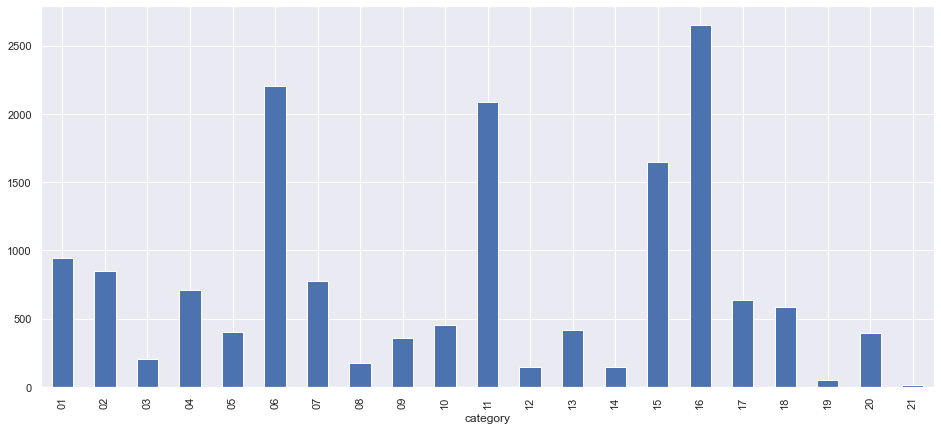

In [38]:
#Plot the distribution of news articles by category
hs_df.groupby('category').category_id.count().plot.bar(ylim=0,figsize = (16, 7))

In [39]:
# Drop duplicate data
hs_df.drop_duplicates(subset=['category', 'text'], inplace=True)

In [40]:
# Data Cleaning
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", "", text)
    # remove whitespaces
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [41]:
hs_df

,category,text,category_id
0,01,"horses; live, purebred breeding animals - pure...",0
1,01,"horses; live, other than purebred breeding ani...",0
2,01,asses; live - other,0
3,01,mules and hinnies; live- other,0
4,01,"cattle; live, purebred breeding animals - pure...",0
...,...,...,...
17214,19,arms and ammunition; parts and accessories the...,18
17215,20,"furniture; bedding, mattresses, mattress suppo...",19
17216,20,"toys, games and sports requisites; parts and a...",19
17217,20,miscellaneous manufactured articles,19


In [42]:
# creating clean text feature
hs_df['clean_text'] = hs_df['text'].apply(clean_text).str.replace('bn bn ', '')

# creating clean text feature
hs_df['clean_text'] = hs_df['text'].apply(clean_text).str.replace(' bn ', '')

In [43]:
hs_df

,category,text,category_id,clean_text
0,01,"horses; live, purebred breeding animals - pure...",0,horseslivepurebredbreedinganimalspurebredbreed...
1,01,"horses; live, other than purebred breeding ani...",0,horsesliveotherthanpurebredbreedinganimalsother
2,01,asses; live - other,0,assesliveother
3,01,mules and hinnies; live- other,0,mulesandhinniesliveother
4,01,"cattle; live, purebred breeding animals - pure...",0,cattlelivepurebredbreedinganimalspurebredbreed...
...,...,...,...,...
17214,19,arms and ammunition; parts and accessories the...,18,armsandammunitionpartsandaccessoriesthereof
17215,20,"furniture; bedding, mattresses, mattress suppo...",19,furniturebeddingmattressesmattresssupportscush...
17216,20,"toys, games and sports requisites; parts and a...",19,toysgamesandsportsrequisitespartsandaccessorie...
17217,20,miscellaneous manufactured articles,19,miscellaneousmanufacturedarticles


In [26]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

In [25]:
# plot 25 most frequent words including stop words
freq_words(hs_df['clean_text'], 25)

TypeError: sequence item 94027: expected str instance, float found

In [22]:
# stopwords-to compare text data with and without stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
hs_df['clean_text'] =hs_df['clean_text'].apply(lambda x: remove_stopwords(x))

KeyError: 'clean_text'

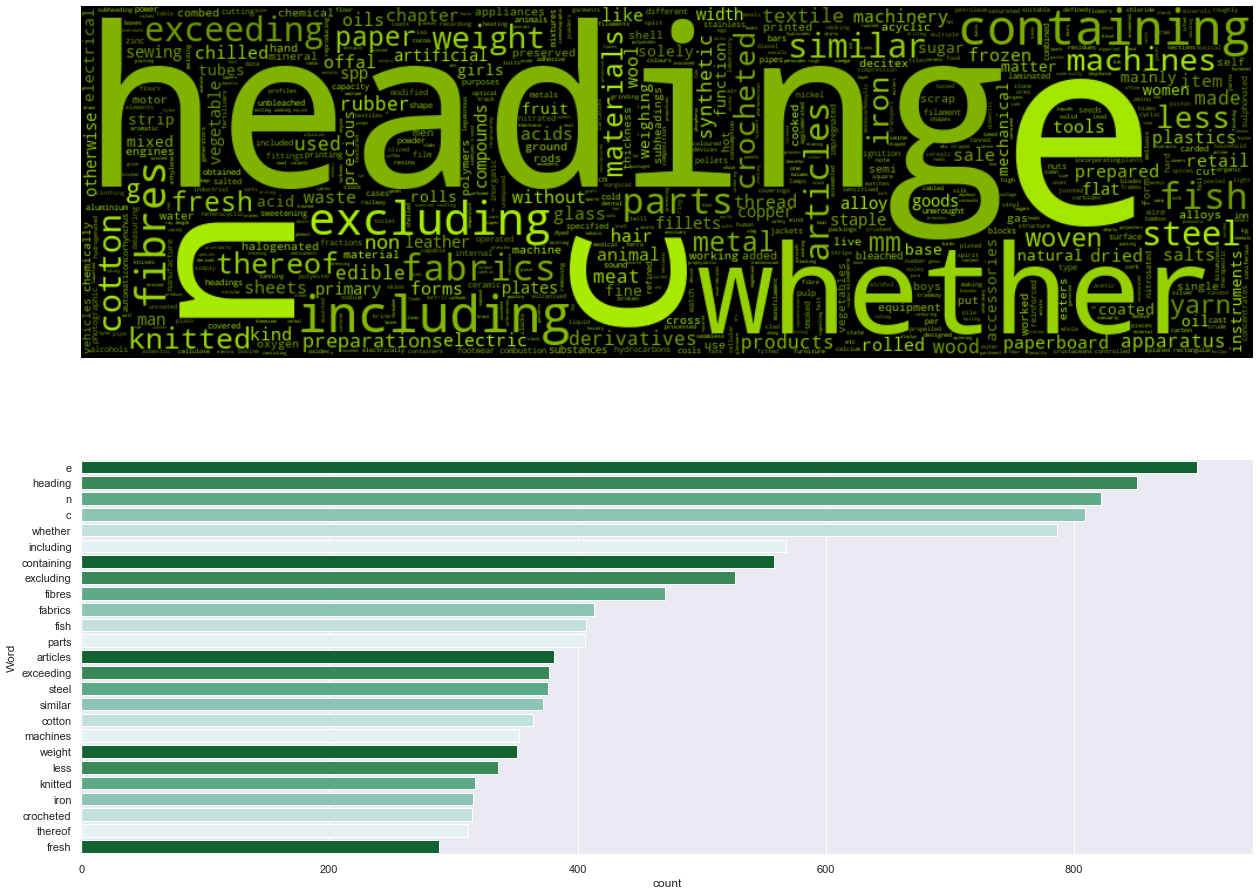

In [41]:
# plot 25 most frequent words without stopwords
freq_words(hs_df['clean_text'], 25)

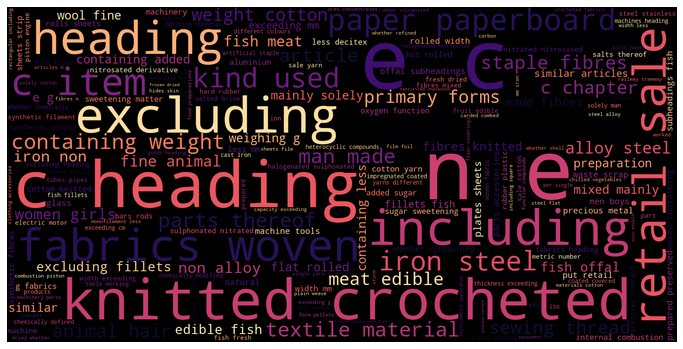

In [42]:
text = " ".join(review for review in hs_df.clean_text)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

In [43]:
wordcloud.to_file("wordcloud.png")

In [44]:
hs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6387 entries, 0 to 6572
Data columns (total 4 columns):
category       6387 non-null object
text           6387 non-null object
category_id    6387 non-null int64
clean_text     6387 non-null object
dtypes: int64(1), object(3)
memory usage: 249.5+ KB


## Heading to Machine Learning

In [45]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [46]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

features = tfidf_vec.fit_transform(hs_df.clean_text).toarray() # Remaps the words in the 2225 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = hs_df.category_id                           # represents the category of each of the 2225 articles


In [47]:
#Get a feel of the features identified by tfidf
features.shape # How many features are there ? 

(6387, 10000)

In [48]:
# Remember the dictionary created to map category names to a number ? 
category_to_id.items()

dict_items([('01', 0), ('02', 1), ('03', 2), ('04', 3), ('05', 4), ('06', 5), ('07', 6), ('08', 7), ('09', 8), ('10', 9), ('11', 10), ('12', 11), ('13', 12), ('14', 13), ('15', 14), ('16', 15), ('17', 16), ('18', 17), ('19', 18), ('20', 19), ('21', 20)])

In [49]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('01', 0),
 ('02', 1),
 ('03', 2),
 ('04', 3),
 ('05', 4),
 ('06', 5),
 ('07', 6),
 ('08', 7),
 ('09', 8),
 ('10', 9),
 ('11', 10),
 ('12', 11),
 ('13', 12),
 ('14', 13),
 ('15', 14),
 ('16', 15),
 ('17', 16),
 ('18', 17),
 ('19', 18),
 ('20', 19),
 ('21', 20)]

In [50]:
hs_df.to_csv('data/out_df.csv', index=False)
print("success")

success


In [51]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# '01':
  . Most correlated unigrams:
       . meat
       . fillet
       . fish
  . Most correlated bigrams:
       . excluding fillet
       . fish meat
       . meat edible
# '02':
  . Most correlated unigrams:
       . fruit
       . fresh
       . seed
  . Most correlated bigrams:
       . crushed ground
       . fresh dried
       . fruit edible
# '03':
  . Most correlated unigrams:
       . oil
       . modified
       . fraction
  . Most correlated bigrams:
       . refined chemically
       . chemically modified
       . oil fraction
# '04':
  . Most correlated unigrams:
       . prepared
       . sugar
       . preserved
  . Most correlated bigrams:
       . containing added
       . food preparation
       . prepared preserved
# '05':
  . Most correlated unigrams:
       . petroleum
       . concentrate
       . ore
  . Most correlated bigrams:
       . slab rectangular
       . sawing block
       . ore concentrate
# '06':
  . Most correlated unigrams:
       . acid
      

In [52]:
features_chi2

(array([0.00178533, 0.00117209, 0.00089565, ..., 0.00142557, 0.00255338,
        0.00459604]),
 array([0.96629686, 0.97268909, 0.97612501, ..., 0.96988169, 0.95969923,
        0.94594956]))

In [53]:
hs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6387 entries, 0 to 6572
Data columns (total 4 columns):
category       6387 non-null object
text           6387 non-null object
category_id    6387 non-null int64
clean_text     6387 non-null object
dtypes: int64(1), object(3)
memory usage: 249.5+ KB


In [54]:
X = hs_df.loc[:,'clean_text']
y = hs_df.loc[:,'category_id']

# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, hs_df.index, test_size=0.2, random_state=55)

# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
#xcv_tfidf = tfidf_vec.fit_transform(X_cv)
xtrain_tfidf.shape

(5109, 10000)

In [55]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtrain_cv.shape

(5109, 5253)

## Model Training and Evaluation

In [56]:
#create list of model and accuracy dicts
perform_list = []

def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)        

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [57]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 94.13
Precision : 0.9413145539906104
Recall    : 0.9413145539906104
F1-score   : 0.9413145539906103


In [58]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 91.08
Precision : 0.9107981220657277
Recall    : 0.9107981220657277
F1-score   : 0.9107981220657277


In [59]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 88.65
Precision : 0.8865414710485133
Recall    : 0.8865414710485133
F1-score   : 0.8865414710485133


In [60]:
run_model('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 96.71
Precision : 0.9671361502347418
Recall    : 0.9671361502347418
F1-score   : 0.9671361502347418


## Performance metrics of models

In [61]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,94.13,0.94,0.94,0.94
1,Logistic Regression,91.08,0.91,0.91,0.91
2,Multinomial Naive Bayes,88.65,0.89,0.89,0.89
3,Linear SVC,96.71,0.97,0.97,0.97


## Optimization 

### RandomForest GridCV

In [62]:
param = {'estimator__penalty':['l1', 'l2'], 'estimator__C':[0.001, 0.01, 1, 10]}

opt_mdl = LogisticRegression()
oneVsRest = OneVsRestClassifier(opt_mdl)
oneVsRest.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [63]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
lr_grid = GridSearchCV(oneVsRest, param_grid = param, cv = kf, scoring='f1_micro', n_jobs=-1)
lr_grid.fit(xtrain_tfidf, y_train)
lr_grid.best_params_

{'estimator__C': 10, 'estimator__penalty': 'l2'}

In [64]:
run_model('Logistic Regression GridSearchCV',lr_grid.best_params_['estimator__C'],lr_grid.best_params_['estimator__penalty'])

Test Accuracy Score of Basic Logistic Regression GridSearchCV: % 95.7
Precision : 0.956964006259781
Recall    : 0.956964006259781
F1-score   : 0.956964006259781


## Model Performans after Optimization

In [65]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,94.13,0.94,0.94,0.94
1,Logistic Regression,91.08,0.91,0.91,0.91
2,Multinomial Naive Bayes,88.65,0.89,0.89,0.89
3,Linear SVC,96.71,0.97,0.97,0.97
4,Logistic Regression GridSearchCV,95.70,0.96,0.96,0.96
